<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://raw.githubusercontent.com/Unidata/MetPy/master/src/metpy/plots/_static/unidata_150x150.png" alt="Unidata Logo" style="height: 98px;">
</div>

<h1>Current weather data: coversion to point vortices plus U(y) at 500 hPa</h1>
        
<h3>Adapted from: Bonus: Using Siphon to query the NetCDF Subset Service</h3>
<h4>in Unidata Python Workshop</h4>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

Uses [MetPy](https://unidata.github.io/MetPy/latest/) and [Siphon](https://unidata.github.io/siphon/latest/) and [xarray](https://xarray.pydata.org/en/stable/index.html).

### Data from current GFS on 500mb:
* u-wind component
* absolute vorticity

### Calculations:
* Contours of smoothed vorticity (centroids ~> point vortices)
* Zonal mean U(y)

In [1]:
%matplotlib inline

from siphon.catalog import TDSCatalog
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/'
                      'Global_onedeg/catalog.xml?dataset=grib/NCEP/GFS/Global_onedeg/Best')
best_gfs.datasets

['Best GFS One Degree Forecast Time Series']

In [2]:
best_ds = list(best_gfs.datasets.values())[0]
ncss = best_ds.subset()

We can look at the `ncss.variables` object to see what variables are available from the dataset:

In [3]:
query = ncss.query()

In [4]:
ncss.variables

{'Absolute_vorticity_isobaric',
 'Albedo_surface_Mixed_intervals_Average',
 'Apparent_temperature_height_above_ground',
 'Best_4_layer_Lifted_Index_surface',
 'Categorical_Freezing_Rain_surface',
 'Categorical_Freezing_Rain_surface_Mixed_intervals_Average',
 'Categorical_Ice_Pellets_surface',
 'Categorical_Ice_Pellets_surface_Mixed_intervals_Average',
 'Categorical_Rain_surface',
 'Categorical_Rain_surface_Mixed_intervals_Average',
 'Categorical_Snow_surface',
 'Categorical_Snow_surface_Mixed_intervals_Average',
 'Cloud_Work_Function_entire_atmosphere_single_layer_Mixed_intervals_Average',
 'Cloud_mixing_ratio_hybrid',
 'Cloud_mixing_ratio_isobaric',
 'Cloud_water_entire_atmosphere_single_layer',
 'Composite_reflectivity_entire_atmosphere',
 'Convective_Precipitation_Rate_surface_Mixed_intervals_Average',
 'Convective_available_potential_energy_pressure_difference_layer',
 'Convective_available_potential_energy_surface',
 'Convective_inhibition_pressure_difference_layer',
 'Convective_

In [5]:
from datetime import datetime
query.lonlat_box(north=60, south=10, east=340, west=240).time(datetime.utcnow())
query.vertical_level(50000) # Pascals? Yes according to this example, but CAREFUL!
# https://unidata.github.io/siphon/latest/examples/ncss/NCSS_Timeseries_Examples.html?highlight=vertical
query.accept('netcdf4')
query.variables('Absolute_vorticity_isobaric')
query.variables('u-component_of_wind_isobaric')

var=Absolute_vorticity_isobaric&var=u-component_of_wind_isobaric&time=2021-09-27T13%3A04%3A08.164013&west=240&east=340&south=10&north=60&vertCoord=50000&accept=netcdf4

We now request data from the server using this query. The `NCSS` class handles parsing this NetCDF data (using the `netCDF4` module). If we print out the variable names, we see our requested variables, as well as a few others (more metadata information)

In [6]:
from xarray.backends import NetCDF4DataStore
import xarray as xr

data = ncss.get_data(query)
data = xr.open_dataset(NetCDF4DataStore(data))

list(data)

['Absolute_vorticity_isobaric',
 'LatLon_Projection',
 'u-component_of_wind_isobaric']

In [7]:
absvor = data['Absolute_vorticity_isobaric']
u500 = data['u-component_of_wind_isobaric']

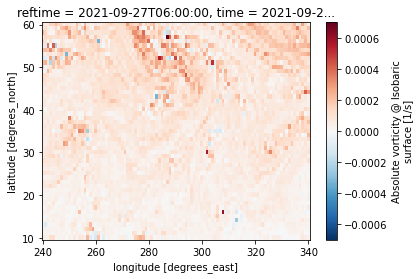

In [25]:
absvor.plot()

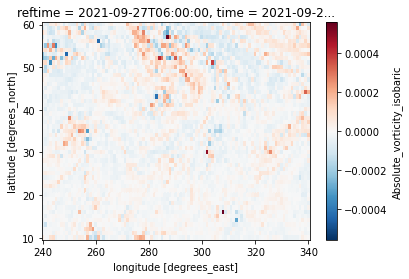

In [9]:
eddyavor = absvor - absvor.mean(dim='lon')
eddyavor.plot()

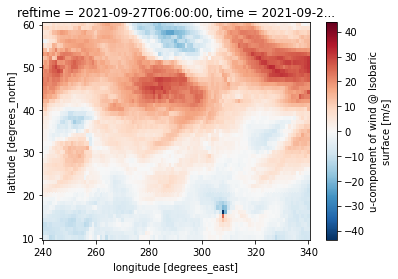

In [12]:
# Quick check: 
u500.plot()

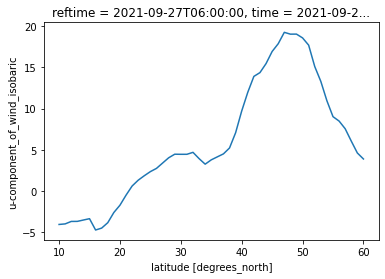

In [13]:
u500.mean(dim='lon').plot()

We'll pull out the useful variables for latitude, and longitude, and time (which is the time, in hours since the forecast run). Notice the variable names are labeled to show how many dimensions each variable is. This will come in to play soon when we prepare to plot. 

In [14]:
# Helper function for finding proper time variable
def find_time_var(var, time_basename='time'):
    for coord_name in var.coords:
        if coord_name.startswith(time_basename):
            return var.coords[coord_name]
    raise ValueError('No time variable found for ' + var.name)

In [15]:
time_1d = find_time_var(u500)
lat_1d = data['lat']
lon_1d = data['lon']
time_1d

<xarray.DataArray 'time' (time: 1)>
array(['2021-09-27T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
    reftime  (time) datetime64[ns] ...
  * time     (time) datetime64[ns] 2021-09-27T12:00:00
Attributes:
    standard_name:        time
    long_name:            GRIB forecast or observation time
    _CoordinateAxisType:  Time

Now we make our data suitable for plotting. We'll import numpy so we can combine lat/longs (meshgrid) and remove one-dimensional entities from our arrays (squeeze). Also we'll use netCDF4's num2date to change the time since the model run to an actual date. 

In [16]:
import numpy as np
from metpy.units import units

# Reduce the dimensions of the data and get as an array with units
u500u = u500.metpy.unit_array.squeeze()
avor = absvor.metpy.unit_array.squeeze()

# Combine latitude and longitudes 
lon_2d, lat_2d = np.meshgrid(lon_1d, lat_1d)

# Relative vorticity (subtract off f)
# planvor = 2 * (2*np.pi/86400.) * np.sin(lat_2d *3.14159/180.) *units('1/second')
relvor = avor -  2 * (2*np.pi/86400.) * np.sin(lat_2d *3.14159/180.) *units('1/second')

eddyrelvor = relvor - np.mean(relvor,1)

# Contour interval for vorticity
clev_vor = np.arange(-20, 21, 2) * 1.0E-5

ValueError: operands could not be broadcast together with shapes (51,101) (51,) 

Now we can plot these up using matplotlib. We import cartopy and matplotlib classes, create our figure, add a map, then add the  data and grid points.

In [17]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from metpy.plots import ctables


# Create a new figure
fig = plt.figure(figsize=(15, 12))

# Add the map and set the extent
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([240, 340, 10, 50])

# Retrieve the state boundaries using cFeature and add to plot
ax.add_feature(cfeature.COASTLINE, edgecolor='gray')
ax.add_feature(cfeature.STATES, edgecolor='gray')

# Contour temperature at each lat/long
contours = ax.contourf(lon_2d, lat_2d, relvor, clev_vor, transform=ccrs.PlateCarree(),
                       cmap='RdBu_r')
#Plot a colorbar to show temperature and reduce the size of it
fig.colorbar(contours)

# Make a title with the time value
ax.set_title(f'vorticity for {time_1d[0].values}Z', fontsize=20)

# Plot markers for each lat/long to show grid points for 0.25 deg GFS
ax.plot(lon_2d.flatten(), lat_2d.flatten(), linestyle='none', marker='o',
        color='black', markersize=2, alpha=0.3, transform=ccrs.PlateCarree());

NameError: name 'clev_vor' is not defined

/Users/bem/opt/miniconda3/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

<Figure size 1080x864 with 1 Axes>

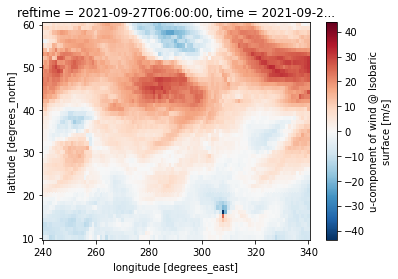

In [18]:
u500.plot()

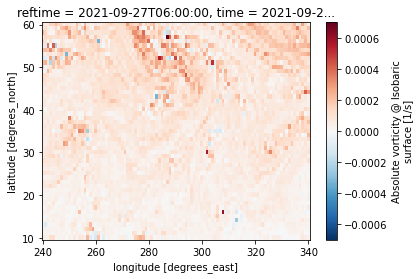

In [19]:
absvor.plot()

In [132]:
u500.mean()

<xarray.DataArray 'u-component_of_wind_isobaric' ()>
array(-11.156219, dtype=float32)

In [21]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import metpy.constants as mpconstants
import numpy as np
import xarray as xr

from metpy.units import units
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS

In [24]:
# Case Study Date
year = 1993
month = 3
day = 13
hour = 0

dt = datetime(year, month, day, hour)

In [23]:
# Read NARR Data from THREDDS server
base_url = 'https://www.ncei.noaa.gov/thredds/catalog/model-narr-a-files/'

# Programmatically generate the URL to the day of data we want
cat = TDSCatalog(f'{base_url}{dt:%Y%m}/{dt:%Y%m%d}/catalog.xml')

# Have Siphon find the appropriate dataset
tds_ds = cat.datasets.filter_time_nearest(dt)

# Interface with the data through the NetCDF Subset Service (NCSS) 
ncss = tds_ds.subset()

# Create an NCSS query with our desired specifications
query = ncss.query()
query.lonlat_box(north=60, south=18, east=300, west=225)
query.time(dt)
query.add_lonlat()
query.accept('netcdf')
query.variables('Geopotential_height_isobaric',
                'Temperature_isobaric',
                'u-component_of_wind_isobaric',
                'v-component_of_wind_isobaric')

# Use the query to obtain our NetCDF data
data = ncss.get_data(query)

HTTPError: 502 Server Error: Proxy Error for url: https://www.ncei.noaa.gov/thredds/catalog/model-narr-a-files/199303/19930313/catalog.xml

In [ ]:
# Open data with xarray, and parse it with MetPy
ds = xr.open_dataset(xr.backends.NetCDF4DataStore(data)).metpy.parse_cf()
ds

In [ ]:
# This is the time we're using, any field has the time coordinate
vtime = ds['Temperature_isobaric'].metpy.time[0]

# Grab lat/lon values from file as unit arrays
lats = ds['lat'].metpy.unit_array
lons = ds['lon'].metpy.unit_array

# Calculate distance between grid points
# will need for computations later
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

# Grabbing data for specific variable contained in file (as a unit array)

# 500 hPa u-component_of_wind
uwnd_500 = ds['u-component_of_wind_isobaric'].metpy.sel(vertical=500 * units.hPa,
                                                        time=vtime)

# 500 hPa v-component_of_wind
vwnd_500 = ds['v-component_of_wind_isobaric'].metpy.sel(vertical=500 * units.hPa,
                                                        time=vtime)

In [ ]:
# Relative vorticity = Absolute Vorticity at lats=0
rvor_500 = mpcalc.absolute_vorticity(uwnd_500, vwnd_500, dx, dy, lats*0)

In [ ]:
# Smooth vorticity

# Number of repetitions of smoothing function
n_reps = 50

# Apply the 9-point smoother
rvor_500s = mpcalc.smooth_n_point(rvor_500, 9, n_reps)#.metpy.unit_array

In [ ]:
# np.max(rvor_500s)*1e4 about 2*f0 is about the biggest 

# CINT vorticity
clev_vor = np.arange(-20, 21, 2) * 1.0E-5

In [ ]:
clev_vor

In [ ]:
# Set some projections for our data (Plate Carree)
# and output maps (Lambert Conformal)

# Data projection; NARR Data is Earth Relative
dataproj = ccrs.PlateCarree()

# Plot projection
# The look you want for the view, LambertConformal for mid-latitude view
plotproj = ccrs.LambertConformal(central_longitude=-100.,
                                 central_latitude=40.,
                                 standard_parallels=[30, 60])

In [ ]:
# Set figure size
fig=plt.figure(1, figsize=(24.5,17.))

# Format the valid time
vtime_str = str(vtime.dt.strftime('%Y-%m-%d %H%MZ').values)

# Upper-Left Panel
ax=plt.subplot(111, projection=plotproj)
ax.set_extent([-150., -50, 10., 60.],ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Contour #1
cs = ax.contour(lons, lats, rvor_500s, clev_vor, colors='k',
                linewidths=1.5, linestyles='solid', transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i',
           rightside_up=True, use_clabeltext=True)

pixels = ax.pcolormesh(lons, lats, rvor_500s, transform=dataproj)

plt.show

In [ ]:
zonalmean = rvor_500s.groupby(ds['lat']).mean()

In [ ]:
zonalmean.plot()